In [1]:
import matplotlib.pyplot as plt

import numpy as np
from timescales.est import fit_acf

from timescales.sim.exp import sim_spikes_synaptic, sim_poisson_distribution, sim_synaptic_kernel
from timescales.est import exp_decay_func

### Estimating Neuronal Populations

We start with a single simulated spike train, which will be subsequently used to estimate a neuronal spiking population.

Next, a kernel is estimated from the ISI distribution (using the isi mean as the kernel length and isi median as tau). This kernel is convolved with the spikes of the original train to produce a spiking probability density.

Finally, a population of neurons is simulated, whose timescale estimate is now more accurate to ground truth. This method may be useful for estimating more accurate timescales from individial spike trains. 

Tau Sim:  0.01
Tau Est:  0.011256320641136977


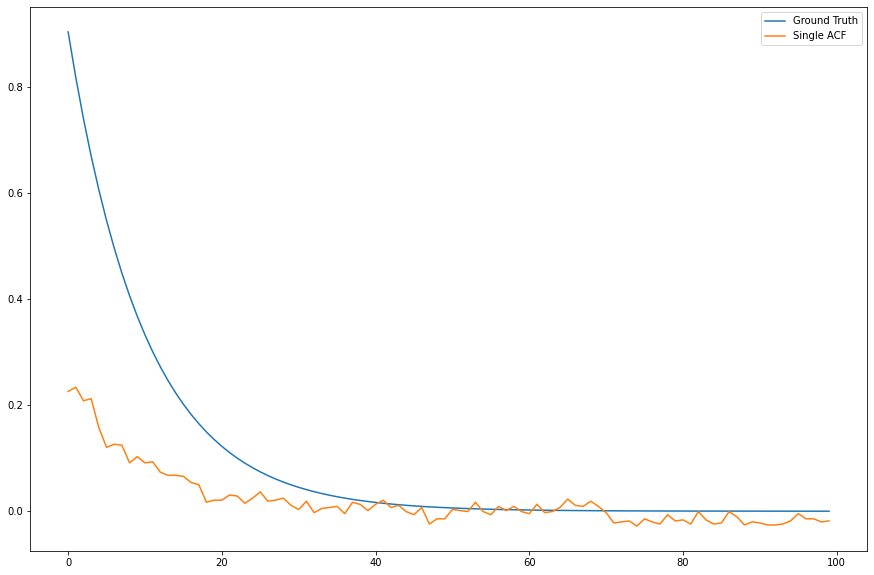

In [2]:
# Starting with a single spikes train
n_seconds = 10
fs = 1000
tau = 0.01
nlags = 100
n_neurons = 1
mu = 100

spikes = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=n_neurons, mu=mu)

# Compare to ground truth
fig = plt.figure(figsize=(15, 10))
corrs_true = np.exp(-np.arange(nlags + 1) / (fs * tau))[1:]
plt.plot(corrs_true, label='Ground Truth')

corrs, params = fit_acf(spikes, nlags, n_jobs=-1)
plt.plot(corrs, label='Single ACF')
plt.legend();
print('Tau Sim: ', tau)
print('Tau Est: ', params[1]/fs)

In [3]:
isi = np.diff(np.where(spikes))[0]
              
isi_mean = round(np.mean(isi))
isi_med = round(np.median(isi))

kernel = sim_synaptic_kernel(1, isi_mean, 0, isi_med/isi_mean)

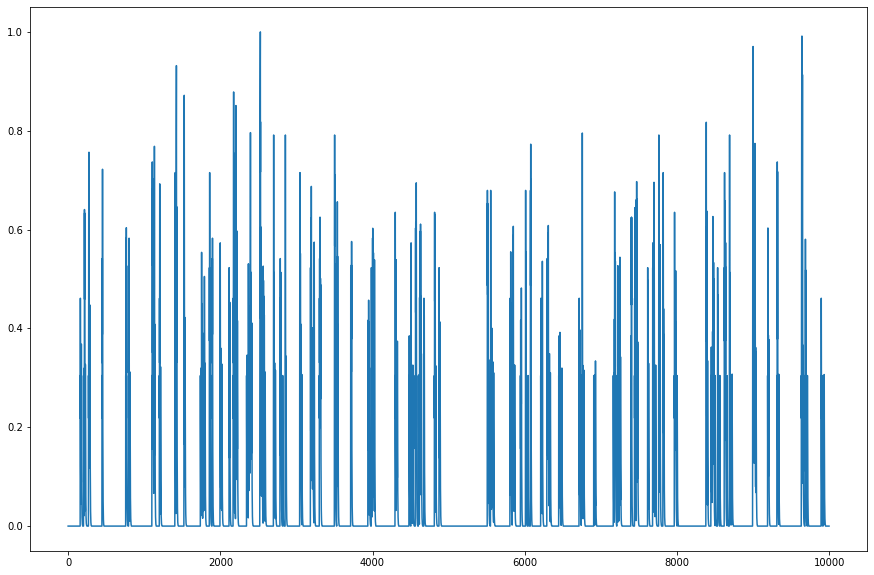

In [4]:
fig = plt.figure(figsize=(15, 10))
poisson = np.pad(spikes, 10*fs)[int(10*fs):]

probs = np.convolve(poisson, kernel, 'valid')[:int(10*fs)]

probs = (probs - np.min(probs)) / np.ptp(probs)

plt.plot(probs)

In [5]:
# Select [0=no spike, 1=spike] using probabilities
n_neurons = 100

spikes = np.zeros((n_neurons, len(probs)), dtype=bool)

for ind in range(n_neurons):
    spikes[ind] = (probs > np.random.rand(*probs.shape))

In [6]:
corrs_pop, params_pop = fit_acf(spikes.sum(axis=0), nlags, n_jobs=-1)

Tau Sim       :  0.01
Tau Est Single:  0.011256320641136977
Tau Est Pop   :  0.010463686021333274


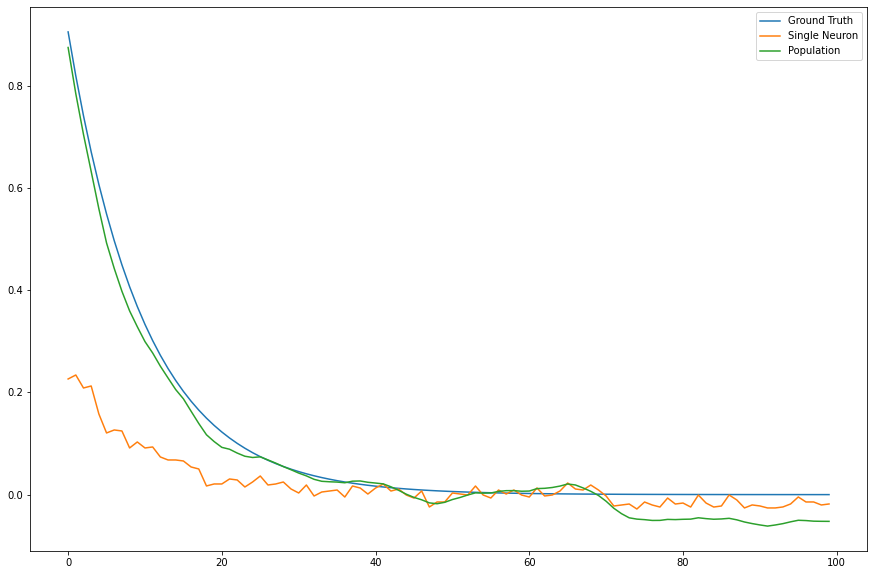

In [7]:
# Compare to ground truth
corrs_true = np.exp(-np.arange(nlags + 1) / (fs * tau))[1:]
fig = plt.figure(figsize=(15, 10))
plt.plot(corrs_true, label='Ground Truth')


print('Tau Sim       : ', tau)
print('Tau Est Single: ', params[1]/fs)
print('Tau Est Pop   : ', params_pop[1]/fs)

plt.plot(corrs, label='Single Neuron')
plt.plot(corrs_pop, label='Population')
plt.legend();